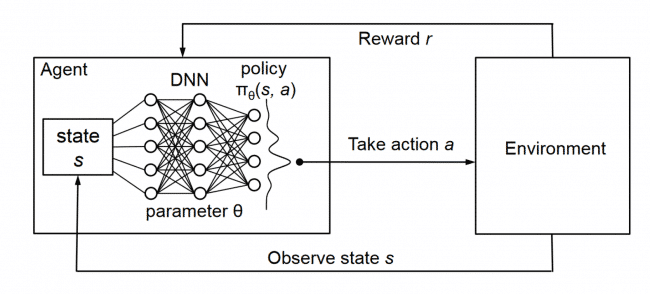

# Imports

In [217]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import itertools
import random
import copy
import sys
import pygame
from IPython import display
from IPython.display import clear_output


# Plot Tool

In [211]:
plt.ion()
def plot_graphs(*graphs):
    display.clear_output(wait=True)
    # display.display(plt.gcf())   
    
    plt.clf() # Clear plot

    plt.title('DQN Agent Training process...')
    plt.xlabel('Number of Episodes')
    plt.ylabel('Values')
    
    for graph in graphs:
        plt.plot(graph)
        plt.text(len(graph)-1, graph[-1], str(round(graph[-1],2)))
    
    plt.ylim(ymin=0)    
    
    plt.show(block=False)
#     plt.pause(0.05)

# Video Engine

In [212]:
class VideoEngine:
    # Colors
    BLUE = (0, 0, 255, 1)
    YELLOW = (240, 210, 100)
    BLACK = (0, 0, 0)
    BROWN = (160, 82, 45)
    WHITE = (255, 255, 255)
    SANDSTONE= (151, 149, 124)
    SANDSONE_HOVER = (186, 181, 153)
    GREY = (200, 200, 200)
    RED = (255, 0, 0)
    GRASS_GREEN = (32, 162, 57)
    DODGER_BLUE = (30, 144, 255)
    LIGHT_GREEN = (144, 238, 144)
    CRIMSON = (220, 20, 60)
    NEON_BLUE = (122, 210, 255)

    def __init__(self, screen_size, tile_size, game_name, bg_image=None, game_tiles=None):
        # Global variables
        pygame.init()
        self.clock = pygame.time.Clock()
        self.fps = 40
        self.screen = pygame.display.set_mode((screen_size[0], screen_size[1]))
        pygame.display.set_caption(game_name)

        self.bg_image = bg_image
        if bg_image:
            self.bg_image = pygame.image.load(bg_image).convert()
            self.bg_image = pygame.transform.scale(self.bg_image, screen_size)

        self.screen_size = screen_size
        self.ts = tile_size
        self.t_in_row = int(self.screen_size[0] / self.ts)
        self.t_in_col = int(self.screen_size[1] / self.ts)
        self.tiles = game_tiles

    def render(self, grid=False, game_objects=None):
        """Draws main screen background image,tiles and grid"""
        self.clock.tick(self.fps)  # Cycles per second
        action = self.keyboard_mouse_events()

        if self.bg_image:
            self.screen.blit(self.bg_image, [0, 0])
        else:
            self.screen.fill(self.LIGHT_GREEN)

        if grid: self.draw_grid()
        if game_objects: self.draw_objects(game_objects)
        pygame.display.flip()
        return action


    def draw_objects(self, game_objects):
        for game_object in game_objects:
            for coord in game_object.body:
                if coord:
                    cell_y, cell_x = coord
                    pygame.draw.rect(self.screen, game_object.color,
                                     pygame.Rect(cell_x * self.ts, cell_y * self.ts, self.ts, self.ts))


    def draw_grid(self):
        for x in range(self.t_in_row + 1):
            for y in range(self.t_in_col + 1):
                pygame.draw.line(self.screen, self.GREY, [0, y * self.ts], [self.screen_size[0], y * self.ts])
            pygame.draw.line(self.screen, self.GREY, [x * self.ts, 0], [x * self.ts, self.screen_size[1]])


    def mouse_left_click(self, mouse_pos):
        mouse_x = mouse_pos[0] // self.ts
        mouse_y = mouse_pos[1] // self.ts
        return mouse_x, mouse_y


    def keyboard_mouse_events(self):
        """Checks keyboard/mouse actions and return Human click coordinates"""
        for event in pygame.event.get():

            if event.type == pygame.QUIT:
                pygame.display.quit()
                pygame.quit()
                sys.exit()

#             elif event.type == pygame.KEYDOWN:

#                 if event.key == pygame.K_UP:
#                     return 'UP'

#                 elif event.key == pygame.K_DOWN:
#                     return 'DOWN'

#                 elif event.key == pygame.K_LEFT:
#                     return 'LEFT'

#                 elif event.key == pygame.K_RIGHT:
#                     return 'RIGHT'


# Environment

In [265]:
class Apple:
    def __init__(self, row, col, snake_body):
        self.row = row
        self.col = col
        self.body = self.create(snake_body)
        self.color = (220, 20, 60)

    def create(self, snake_body):
        """Creates a randomly placed apple
         :return [(x,y)] coordinate"""

        while True:
            apple_body = [(random.randint(0, self.row - 1),
                      random.randint(0, self.col - 1))]            
            if apple_body[0] not in snake_body:
                break
        return apple_body


class Snake:
    def __init__(self, row, col):
        self.row = row
        self.col = col
        self.body = self.create()
        self.color = (30, 144, 255)

        self.directions = ('NORTH', 'EAST', 'SOUTH', 'WEST')
        self.direction = 'NORTH'

    def create(self):
        """Returns an initial snake's body list: (the head in the middle, 1 peace of the body)"""
        self.direction = 'NORTH'
        self.body = [(15, 15),(16,15),(17,15)]
        return self.body

    def move(self, action):
        """ Receives LEFT RIGHT ACTION, checked"""
               
        if action == 0:
            action_id = 'FORWARD'
        elif action == 1:
            action_id = 'RIGHT'
        elif action == 2:
            action_id = 'LEFT'
        else:
            pass
        
        if action_id == 'LEFT':
            self.direction = self.directions[((self.directions.index(self.direction)) - 1) % 4]
        elif action_id == 'RIGHT':
            self.direction = self.directions[((self.directions.index(self.direction)) + 1) % 4]
        else:
            pass


        row = self.body[0][0]
        col = self.body[0][1]
        move_patterns = {'NORTH': (row - 1, col),
                         'SOUTH': (row + 1, col),
                         'WEST': (row, col - 1),
                         'EAST': (row, col + 1)}

        self.body.insert(0, move_patterns[self.direction])       
        return self.body

    def grow(self,apple):
        self.body.insert(0, apple)

    def pop_tale(self):
        self.body.pop()   


class GameEnv:
    def __init__(self):
        self.row = 30
        self.col = 30            
        self.snake = Snake(self.row, self.col)
        self.apple = Apple(self.row, self.col, self.snake.body)        
        self.objects = [self.snake, self.apple] 


        self.record_score = 0
        self.episode_score = 0
        self.steps_in_episode = 0

    def reset(self):
        '''Resets environment in the begining of each episode'''
        self.episode_score = 0
        self.steps_in_episode = 0         
        self.snake.body = self.snake.create()
        self.apple.body = self.apple.create(self.snake.body)
        


    def get_state(self):
        """Returns 2D array (12,1) of state"""
        # state = [dngr_str, dngr_right, dngr_left,
        #          apple_NORTH, apple_SOUTH, apple_WEST, apple_EAST,
        #          dir_NORTH, dir_SOUTH, dir_WEST, dir_EAST]

        apple = self.apple.body[0]        # tuple(row,column)
        apple_row = apple[0]
        apple_col = apple[1]
        snake_head = self.snake.body[0]   # tuple(row,column)
        snake_head_row = snake_head[0]
        snake_head_col = snake_head[1]

        BOARD_STRAIGHT, BOARD_RIGHT, BOARD_LEFT = False, False, False

        if (
                self.snake.direction == 'NORTH' and snake_head_row == 0) or (
                self.snake.direction == 'EAST' and snake_head_col == self.col - 1) or (
                self.snake.direction == 'SOUTH' and snake_head_row == self.row - 1) or (
                self.snake.direction == 'WEST' and snake_head_col == 0):
            BOARD_STRAIGHT = True

        if (
                self.snake.direction == 'NORTH' and snake_head_col == self.col - 1) or (
                self.snake.direction == 'EAST' and snake_head_row == self.row - 1) or (
                self.snake.direction == 'SOUTH' and snake_head_col == 0) or (
                self.snake.direction == 'WEST' and snake_head_row == 0):
            BOARD_RIGHT = True

        if (
                self.snake.direction == 'NORTH' and snake_head_col == 0) or (
                self.snake.direction == 'EAST' and snake_head_row == 0) or (
                self.snake.direction == 'SOUTH' and snake_head_col == self.col - 1) or (
                self.snake.direction == 'WEST' and snake_head_row == self.row - 1):
            BOARD_LEFT = True

        straight_point_patterns = {
            'NORTH': (snake_head_row - 1, snake_head_col),
            'EAST': (snake_head_row, snake_head_col + 1),
            'SOUTH': (snake_head_row + 1, snake_head_col),
            'WEST': (snake_head_row, snake_head_col - 1)}

        right_point_patterns = {
            'NORTH': (snake_head_row, snake_head_col + 1),
            'EAST': (snake_head_row + 1, snake_head_col),
            'SOUTH': (snake_head_row, snake_head_col - 1),
            'WEST': (snake_head_row - 1, snake_head_col)}

        left_point_patterns = {
            'NORTH': (snake_head_row, snake_head_col - 1),
            'EAST': (snake_head_row - 1, snake_head_col),
            'SOUTH': (snake_head_row, snake_head_col + 1),
            'WEST': (snake_head_row + 1, snake_head_col)}

        straight_point = straight_point_patterns[self.snake.direction]
        right_point = right_point_patterns[self.snake.direction]
        left_point = left_point_patterns[self.snake.direction]

        # 
        North_vision = list(itertools.product([*range(0,snake_head_row)],[snake_head_col]))
        South_vision = list(itertools.product([*range(snake_head_row+1,self.row)],[snake_head_col]))

        East_vision = list(itertools.product([snake_head_row],[*range(snake_head_col+1,self.col)]))
        West_vision = list(itertools.product([snake_head_row],[*range(0,snake_head_col)]))

        
        straight_direction_vision = {
            'NORTH': North_vision,
            'EAST': East_vision,
            'SOUTH': South_vision,
            'WEST': West_vision}

        right_direction_vision = {
            'NORTH':  East_vision,
            'EAST': South_vision,
            'SOUTH': West_vision,
            'WEST': North_vision}

        left_direction_vision = {
            'NORTH': West_vision,
            'EAST': North_vision,
            'SOUTH': East_vision,
            'WEST': South_vision}
        
        
        
        

        state = [
            # Danger straight
            straight_point in self.snake.body or BOARD_STRAIGHT,

            # Danger right
            right_point in self.snake.body or BOARD_RIGHT,

            # Danger left
            left_point in self.snake.body or BOARD_LEFT,

            # Apple location North
            snake_head_row > apple_row,

            # Apple location East
            snake_head_col < apple_col,

            # Apple location South
            snake_head_row < apple_row,

            # Apple location West
            snake_head_col > apple_col,

            # Snake Direction North
            self.snake.direction == 'NORTH',

            # Snake Direction East
            self.snake.direction == 'EAST',

            # Snake Direction South
            self.snake.direction == 'SOUTH',

            # Snake Direction West
            self.snake.direction == 'WEST',
            
            #Snake body in strainght direction
            bool(list(set(straight_direction_vision[self.snake.direction]).intersection(self.snake.body[2:]))),
            
            #Snake body in right direction
            bool(list(set(right_direction_vision[self.snake.direction]).intersection(self.snake.body[2:]))),
            
            #Snake body in left direction
            bool(list(set(left_direction_vision[self.snake.direction]).intersection(self.snake.body[2:])))
        ]        
        return (np.array([state], dtype=int).T-0.5) / 0.5 # returns 2D array with shape (11,1)


    def is_apple_eaten(self):
        """Checks collision of the snake and an apple """
        return self.snake.body[0] == self.apple.body[0]


    def is_body_collision(self, snake):
        """Checks collision of the snake's head and its body """
        return self.snake.body[0] in self.snake.body[2:]


    def is_boards_collision(self, snake):
        """Checks collision of the snake and game boards """
        if snake.body[0][0] < 0 or snake.body[0][0] > self.row - 1:
            return True
        elif snake.body[0][1] < 0 or snake.body[0][1] > self.col - 1:
            return True
        else:
            return False


    def take_action(self, action):
        # a step in the environment
        state, action, reward, next_state, game_done = self.get_state(), action, None, None, None        

        # Snake takes direction from (0,1,2), and makes a move        
        self.snake.move(action)

        # Check is apple eaten
        if self.is_apple_eaten():            
            self.apple.body = self.apple.create(self.snake.body)
            state, action, reward, next_state, game_done = state, action, 1, self.get_state(), False

            # Making apples records
            self.episode_score += 1
            self.record_score = max(self.episode_score,self.record_score)

            return state, action, reward, next_state, game_done


        self.snake.pop_tale() 

        # Check collision with board
        if self.is_boards_collision(self.snake):
            state, action, reward, next_state, game_done = state, action, -1, None, True

        # Check collision with its body
        elif self.is_body_collision(self.snake):
            state, action, reward, next_state, game_done = state, action, -1, None, True

        # Prevent loop
        elif self.steps_in_episode > len(self.snake.body)*100:
            state, action, reward, next_state, game_done = state, action, 0, None, True

        # Just transit to next state
        else:
            
            self.steps_in_episode += 1
            state, action, reward, next_state, game_done = state, action, 0, self.get_state(), False

        return state, action, reward, next_state, game_done

# Neural Net

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid_derivative(f):
    return np.multiply(f, (1 - f))


def tanh(x):
    return np.tanh(x)


def tanh_derivative(f):
    return 1 - np.power(np.tanh(f), 2)


def relu(x):
    return np.maximum(0, x)


def relu_derivative(z):
    return (z > 0).astype(int)


def noneActivation(x):
    return x    

def noneActivation_derivative(z):
    return 1    


def mean_squared_error(target, output):
    # print('\n Prediction', output)
    # print(target)
    return np.square(target - output).mean()


class MyNeuralNet:
    def __init__(self, input_neurons, hidden_neurons, output_neurons):
        
        # Neural Net Layers and Nodes
        self.i = input_neurons  #
        self.h = hidden_neurons  #
        self.o = output_neurons  #
        
        # Activation functions and derivatives
        self.activation_h =  relu
        self.activation_o =  noneActivation

        self.activation_derivative_h =  relu_derivative
        self.activation_derivative_o =  noneActivation_derivative
        
        # Loss function
        self.loss_function = mean_squared_error
        self.loss = 0
        self.loss_list = []
        
        # Optimizing
        self.lr = 0.001
        self.optimizer = 'ADAM'
        
        # ADAM Optimizer variables
        self.l2_m = 0
        self.l1_m = 0
        self.l3_m = 0
        
        self.l2_v = 0
        self.l1_v = 0
        self.l3_v = 0

        self.lb2_m = 0
        self.lb1_m = 0
        self.lb3_m = 0

        self.lb2_v = 0
        self.lb1_v = 0
        self.lb3_v = 0

        self.t = 0
        
    
    def init_weights(self):     
        '''Creates weights for the Neural Net'''
        # shape (layer, Previous Layer)
        self.weight_h =  np.random.uniform(-np.sqrt(1/self.i) , np.sqrt(1/self.i) ,(self.h, self.i))
        self.weight_o = np.random.uniform(-np.sqrt(1/self.h) , np.sqrt(1/self.h) ,(self.o, self.h))
        # Bias shape(h,1) - only 1 Bias neuron per layer
        self.bias_h =  np.random.uniform(-np.sqrt(1/self.i) , np.sqrt(1/self.i) ,(self.h,1))
        self.bias_o =  np.random.uniform(-np.sqrt(1/self.h) , np.sqrt(1/self.h) ,(self.o, 1))


    def feedforward(self, input_signal):
        """ Input signal should be 2D array shape : (Rows = input layer size (self.i) , Columns = batch_size)"""
        # dot((R1,C1),(R2,C2)) output shape: (R1,C2), C1 == R2
        output_i = input_signal
#         output_i = np.multiply(input_signal,np.random.binomial(1, 1, input_signal.shape)) / np.full(input_signal.shape,0.9)
                               
        output_h = self.activation_h(np.dot(self.weight_h, output_i) + self.bias_h)
#         output_h = np.multiply(output_h, np.random.binomial(1, 1, output_h.shape)) / np.full(output_h.shape,1) # DROPOUT
       
        output_o = self.activation_o(np.dot(self.weight_o, output_h) + self.bias_o)

        return output_i, output_h, output_o #returns tuple
    
    

    def back_propagation(self, output_i, output_h, output_o, target, batch_size):   
        """ Input signal should be 2D array shape : (Rows = input layer size (self.i) , Columns = batch_size)"""
        # Target shape : ( output layer size , batch_size)
        # for graph
        self.loss = self.loss_function(target, output_o)
        if random.uniform(0, 1) > 0.05:
            self.loss_list.append(self.loss)  
        

        error_o = -(2/len(target))*(target - output_o)
       
        delta_o =  error_o * self.activation_derivative_o(output_o) 
        
        grad_o = np.dot(delta_o,  output_h.T) / batch_size     # Correct
        grad_bias_o = np.mean(delta_o, axis=1, keepdims=True)   # Correct 
        
  
        delta_h = np.dot(self.weight_o.T, delta_o) * self.activation_derivative_h(output_h)        
        
        grad_h = np.dot(delta_h, output_i.T) / batch_size    # Correct
        grad_bias_h = np.mean(delta_h, axis=1, keepdims=True)  # Correct  
     
        return grad_h ,grad_o, grad_bias_h, grad_bias_o

    
    
    def update_weights(self, grad_h ,grad_o, grad_bias_h, grad_bias_o):
        '''Returns (weight_h, weight_o, weight_bias_h,  weight_bias_o)'''             
                
        if self.optimizer == 'SGD':
            self.sgd_optimizer( grad_h, grad_o, grad_bias_h, grad_bias_o)

        elif self.optimizer == 'ADAM':
            self.adam_optimizer(grad_h, grad_o, grad_bias_h, grad_bias_o)


    def predict(self, input_signal):
        """ Input signal should be 2D array shape : (Rows = input layer size (self.i) , Columns = batch_size)"""
        # dot((R1,C1),(R2,C2)) output shape: (R1,C2), C1 == R2
        
        output_i = input_signal
        output_h = self.activation_h(np.dot(self.weight_h, output_i) + self.bias_h)
        output_o = self.activation_o(np.dot(self.weight_o, output_h) + self.bias_o)

        return output_o #returns tuple
    
#         '''Returns only Output Layer array'''
#         _, _, output_o = self.feedforward(input_signal)
#         return output_o
    

        
    def sgd_optimizer(self, grad_h, grad_o, grad_bias_h, grad_bias_o):
        # Update Weights
        self.weight_o = self.weight_o - self.lr * grad_o
        self.weight_h = self.weight_h - self.lr * grad_h

        self.bias_h = self.bias_h - self.lr * grad_bias_h
        self.bias_o = self.bias_o - self.lr * grad_bias_o


    def adam_optimizer(self, grad_h, grad_o, grad_bias_h, grad_bias_o):
        decay_rate_1 = 0.9
        decay_rate_2 = 0.999
        epsilon = 10**(-8)

        g2 = grad_o        
        g0 = grad_h

        gb2 = grad_bias_o
        gb0 = grad_bias_h

        self.t += 1  # Increment Time Step

        # Computing 1st and 2nd moment for each layer
        self.l3_m = self.l3_m * decay_rate_1 + (1 - decay_rate_1) * g2
        self.l1_m = self.l1_m * decay_rate_1 + (1 - decay_rate_1) * g0
        
        self.l3_v = self.l3_v * decay_rate_2 + (1 - decay_rate_2) * np.square(g2)        
        self.l1_v = self.l1_v * decay_rate_2 + (1 - decay_rate_2) * np.square(g0)
        
        self.lb3_m = self.lb3_m * decay_rate_1 + (1 - decay_rate_1) * gb2        
        self.lb1_m = self.lb1_m * decay_rate_1 + (1 - decay_rate_1) * gb0
        
        self.lb3_v = self.lb3_v * decay_rate_2 + (1 - decay_rate_2) * np.square(gb2)        
        self.lb1_v = self.lb1_v * decay_rate_2 + (1 - decay_rate_2) * np.square(gb0)

        # Computing bias-corrected moment
        l3_m_corrected = self.l3_m / (1 - (decay_rate_1 ** self.t))
        l3_v_corrected = self.l3_v / (1 - (decay_rate_2 ** self.t))

        l1_m_corrected = self.l1_m / (1 - (decay_rate_1 ** self.t))
        l1_v_corrected = self.l1_v / (1 - (decay_rate_2 ** self.t))

        lb3_m_corrected = self.lb3_m / (1 - (decay_rate_1 ** self.t))
        lb3_v_corrected = self.lb3_v / (1 - (decay_rate_2 ** self.t))

        lb1_m_corrected = self.lb1_m / (1 - (decay_rate_1 ** self.t))
        lb1_v_corrected = self.lb1_v / (1 - (decay_rate_2 ** self.t))

        # Update Weights
        w2_update = l3_m_corrected / (np.sqrt(l3_v_corrected) + epsilon)        
        w0_update = l1_m_corrected / (np.sqrt(l1_v_corrected) + epsilon)
        b2_update = lb3_m_corrected / (np.sqrt(lb3_v_corrected) + epsilon)        
        b0_update = lb1_m_corrected / (np.sqrt(lb1_v_corrected) + epsilon)

        self.weight_o -= (self.lr * w2_update)        
        self.weight_h -= (self.lr * w0_update)
        self.bias_o -= (self.lr * b2_update)        
        self.bias_h -= (self.lr * b0_update)

        
    def plot_MSE(self):
        y = [self.loss_list[i] for i in range(len(self.loss_list))]
        x = [x for x in range(len(y))]
        plt.plot(x, y)
        plt.xlabel('iterations')
        plt.title('MSE of the NN')
        plt.show()    

    

# DQN Agent

In [266]:
class DqnAgent:
    def __init__(self, agent_id='Snake',
                 state_inputs=14,
                 action_outputs=3,
                 gamma=0.9,
                 exploration_rate=0.5,
                 min_exploration_rate=0.001,
                 exploration_decay_steps=10000,
                 max_memory_size=50_000,
                 batch_size=512):
                
        self.state_inputs = state_inputs
        self.action_outputs = action_outputs        

        self.exploration_rate = exploration_rate
        self.min_exploration_rate = min_exploration_rate
        self.exploration_decay_rate = exploration_rate / exploration_decay_steps

        self.replay_memory = deque(maxlen=max_memory_size)        
        self.batch_size = batch_size
        self.gamma = gamma        
        
        # Neural Networks
        self.policy_net = MyNeuralNet(self.state_inputs, 250, self.action_outputs)
        self.policy_net.init_weights()
        
        # Doube DQN settings
        self.DDQN = False
#         self.target_net = MyNeuralNet(self.state_inputs, 250, self.action_outputs)
#         self.target_net.init_weights()
#         self.update_target_net(TAU=1.0)
       


    def add_to_memory(self, experience):
        '''Adds tuple(s,a,r,ns,d) to the replay memory deque'''
        self.replay_memory.append(experience)
    
           
    def get_action(self, state):
        """ Selects an action. state = 2D array. Return integer from (0,1,2) """
        # Decay for exploration rate
        if self.exploration_rate > self.min_exploration_rate:
            self.exploration_rate -= self.exploration_decay_rate
        
        # Choose action
        if random.uniform(0, 1) > self.exploration_rate:            
            action = np.argmax(self.policy_net.predict(input_signal=state))        
        else:            
            action = random.randint(0, self.action_outputs - 1)
        return action


    def train_short_memory(self, state, action, reward, next_state, done):
        # 1: predicted Q values with current state
        prediction = self.policy_net.predict(state)
        target = np.copy(prediction)
        Q_new = reward
        
        if not done:
            if self.DDQN:
                next_action = np.argmax(self.policy_net.predict(next_state))
                Q_new = reward + self.gamma * self.target_net.predict(next_state)[next_action]
            else:
                Q_new = reward + self.gamma * np.amax(self.policy_net.predict(next_state))
        
        target[action] = Q_new
      
        feedforward = self.policy_net.feedforward(state)
        gradients = self.policy_net.back_propagation(*feedforward, target, 1)
        self.policy_net.update_weights(*gradients)
        
           
    def train_long_memory(self):
        if len(self.replay_memory) > self.batch_size:
            mini_batch = random.sample(self.replay_memory, self.batch_size)
        else:
            mini_batch = self.replay_memory     
            

        # Prepare 2D arrays for batches of state inputs and target outputs
        states = np.zeros((self.state_inputs, len(mini_batch)))
        targets = np.zeros((self.action_outputs, len(mini_batch)))


        # 1. Need to create a target array with new Q value for each experience in batch        
        for index,experience in enumerate(mini_batch):
            state, action, reward, next_state, done = experience # expeirence is a tuple

            # Prediction for online net for the current state
            prediction = self.policy_net.predict(state)
            target = np.copy(prediction)
            Q_new = reward

            if not done:
                if self.DDQN:
                    next_action = np.argmax(self.policy_net.predict(next_state))
                    Q_new = reward + self.gamma * self.target_net.predict(next_state)[next_action]
                else:
                    Q_new = reward + self.gamma * np.amax(self.policy_net.predict(next_state)) 
            
            target[action] = Q_new

            states[:,index] = state[:,0]
            targets[:,index] = target[:,0]            
        

        # 2. Train our Online Net            
        feedforward = self.policy_net.feedforward(states)
        gradients = self.policy_net.back_propagation(*feedforward,targets,len(mini_batch))
        self.policy_net.update_weights(*gradients)   
    
    
    def update_target_net(self, TAU=1 ,episode=0):           
        # if episode % self.update_target_net_episodes == 0:        
        self.target_net.weight_o = self.policy_net.weight_o * TAU + (1 - TAU) * self.target_net.weight_o
        self.target_net.weight_h = self.policy_net.weight_h * TAU + (1 - TAU) * self.target_net.weight_h 
        self.target_net.bias_o   = self.policy_net.bias_o   * TAU + (1 - TAU) * self.target_net.bias_o   
        self.target_net.bias_h   = self.policy_net.bias_h   * TAU + (1 - TAU) * self.target_net.bias_h  

# Main Loop

In [263]:
class AI_plays_Snake:
    def __init__(self):
        # Game objects
        self.env = GameEnv()
        self.agent = DqnAgent('snake')
        
        # Game settings
        self.row = 30
        self.col = 30
        self.max_episodes = 2000        
        self.total_score = 0
        self.record = 0
        self.mean_score_list = []
        self.episode_score_list = []
                
        # Render Settings
        self.tile_size = 20
        self.to_render = False
        if self.to_render:
            self.display = VideoEngine((self.row * self.tile_size, self.col * self.tile_size), self.tile_size, 'Snake')
            

    def train(self):        
        for episode in range(1,self.max_episodes):
            self.env.reset()
            
            while True:
                # Render objects in each step
                if self.to_render: self.display.render(True, self.env.objects)                
                
                # get state
                state = self.env.get_state()   
                
                # Get action from the DQN Agent
                action = self.agent.get_action(state)

                # Perform action in the environment
                state, action, reward, next_state, game_done = self.env.take_action(action)

                # Train the last experience
#                 self.agent.train_short_memory(state, action, reward, next_state, game_done)
                
                
                # Add the last experience to the replay memory
                self.agent.add_to_memory((state, action, reward, next_state, game_done))
                
                if game_done:
                    

                    self.total_score += self.env.episode_score
                    mean_score =  self.total_score / episode     
                    self.episode_score_list.append(self.env.episode_score)
                    self.mean_score_list.append(mean_score)                                        
                    
#                     clear_output(True)
#                     print('Episode: ',episode, 'Mean score:',round(mean_score,2),'Record',self.env.record_score,'\n',flush = True)
                    plot_graphs(self.episode_score_list,self.mean_score_list)                                  

                    # Train agent in the end of each episode on replay memory minibatch
                    self.agent.train_long_memory()                   
                    
                    break        



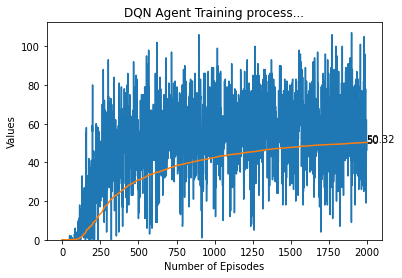

In [246]:
game = AI_plays_Snake()
game.train()

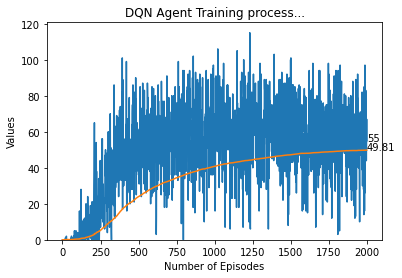

In [245]:
game = AI_plays_Snake()
game.train()

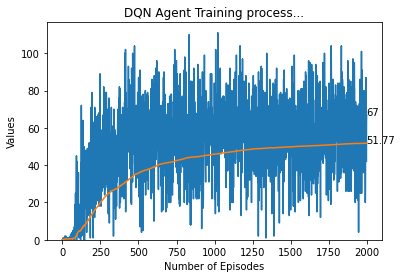

In [267]:
game = AI_plays_Snake()
game.train()